In [1]:
import os
!git clone https://github.com/TieuLongPhan/Database.git
os.chdir("/content/Database/Training_cheminformatics")

fatal: destination path 'Database' already exists and is not an empty directory.


In [2]:
!pip install scikeras rdkit-pypi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **1. Buiding from scratch**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import pandas as pd
data = pd.read_csv('CHEMBL25_activities_EGFR.csv')


# Add column for activity
data["active"] = np.zeros(len(data))
# Mark every molecule as active with an pIC50 of >= 8, 0 otherwise
data.loc[data[data['pIC50'] >= 7].index, "active"] = 1.0
df = data[['active', 'canonical_smiles']]

df.head()

,active,canonical_smiles
0,1.0,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1
1,0.0,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...
2,1.0,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...
3,1.0,Clc1c(OCc2cc(F)ccc2)ccc(Nc2ncnc3c2sc(C#C[C@H]2...
4,0.0,S(Sc1n(C)c2c(c1C(=O)NCC(O)CO)cccc2)c1n(C)c2c(c...


In [5]:
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, AllChem
from rdkit.ML.Descriptors import MoleculeDescriptors
def smiles_to_ecfp(smiles):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    Returns
    -------
    array
        The fingerprint array.
    """

    # Convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    
    return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))
    


df["fp"] = df['canonical_smiles'].apply(smiles_to_ecfp)

X = np.stack(df.fp.values)
y = df['active']

<ipython-input-5-394a9c0e3eee>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["fp"] = df['canonical_smiles'].apply(smiles_to_ecfp)


## 1.1. Multilayer Perceptron Model

In [7]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import tensorflow as tf

# 1. fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 2. split into input (X) and output (Y) variables
X = np.stack(df.fp.values)
y = df['active']

# 3. create model
model = Sequential()
model.add(Dense(1024, input_dim = X.shape[1], kernel_initializer= 'uniform', activation = 'relu'))
model.add(Dense(512, kernel_initializer= 'uniform', activation = 'relu'))
model.add(Dense(1, kernel_initializer= 'uniform', activation = 'sigmoid'))

# 4. Compile model
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# 5. Fit the model
model.fit(X, y, epochs = 20, batch_size = 32, verbose = 1)

# 6. evaluate the model
scores = model.evaluate(X, y)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/20
123/123 [==============================] - 2s 4ms/step - loss: 0.4352 - accuracy: 0.7983
Epoch 2/20
123/123 [==============================] - 0s 4ms/step - loss: 0.2814 - accuracy: 0.8853
Epoch 3/20
123/123 [==============================] - 0s 4ms/step - loss: 0.2041 - accuracy: 0.9124
Epoch 4/20
123/123 [==============================] - 0s 3ms/step - loss: 0.1666 - accuracy: 0.9337
Epoch 5/20
123/123 [==============================] - 1s 6ms/step - loss: 0.1277 - accuracy: 0.9485
Epoch 6/20
123/123 [==============================] - 1s 5ms/step - loss: 0.0890 - accuracy: 0.9629
Epoch 7/20
123/123 [==============================] - 1s 5ms/step - loss: 0.0810 - accuracy: 0.9693
Epoch 8/20
123/123 [==============================] - 1s 5ms/step - loss: 0.0520 - accuracy: 0.9795
Epoch 9/20
123/123 [==============================] - 0s 4ms/step - loss: 0.0586 - accuracy: 0.9775
Epoch 10/20
123/123 [==============================] - 0s 3ms/step - loss: 0.0438 - accuracy: 0.9811

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 2,623,489
Trainable params: 2,623,489
Non-trainable params: 0
_________________________________________________________________


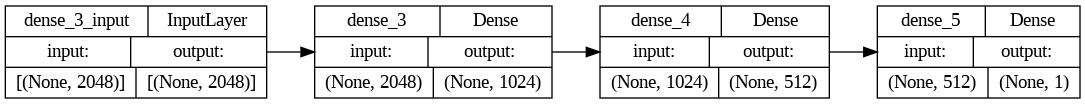

In [10]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, rankdir = 'LR')

## 1.2 Automatical Verification 

- Use validation_split

In [11]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import tensorflow as tf

# 1. fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 2. split into input (X) and output (Y) variables
X = np.stack(df.fp.values)
y = df['active']

# 3. create model
model = Sequential()
model.add(Dense(1024, input_dim = X.shape[1], kernel_initializer= 'uniform', activation = 'relu'))
model.add(Dense(512, kernel_initializer= 'uniform', activation = 'relu'))
model.add(Dense(1, kernel_initializer= 'uniform', activation = 'sigmoid'))

# 4. Compile model
model.compile(loss= 'binary_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])
# 5. Fit the model
model.fit(X, y, epochs=20, batch_size=32, validation_split=0.2, verbose = 1)  # Set validation split = 7-3

Epoch 1/20
98/98 [==============================] - 2s 6ms/step - loss: 0.4616 - accuracy: 0.7827 - val_loss: 0.3408 - val_accuracy: 0.8529
Epoch 2/20
98/98 [==============================] - 0s 4ms/step - loss: 0.2805 - accuracy: 0.8822 - val_loss: 0.3280 - val_accuracy: 0.8568
Epoch 3/20
98/98 [==============================] - 1s 5ms/step - loss: 0.2049 - accuracy: 0.9133 - val_loss: 0.3588 - val_accuracy: 0.8696
Epoch 4/20
98/98 [==============================] - 0s 4ms/step - loss: 0.1459 - accuracy: 0.9427 - val_loss: 0.4419 - val_accuracy: 0.8657
Epoch 5/20
98/98 [==============================] - 1s 6ms/step - loss: 0.1070 - accuracy: 0.9571 - val_loss: 0.4578 - val_accuracy: 0.8632
Epoch 6/20
98/98 [==============================] - 1s 6ms/step - loss: 0.0808 - accuracy: 0.9664 - val_loss: 0.5632 - val_accuracy: 0.8504
Epoch 7/20
98/98 [==============================] - 1s 8ms/step - loss: 0.0674 - accuracy: 0.9738 - val_loss: 0.5829 - val_accuracy: 0.8402
Epoch 8/20
98/98 [==

## 1.3. Manual verification 

- Use validation_data

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf

# 1. fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 2. split into input (X) and output (Y) variables
X = np.stack(df.fp.values)
y = df['active']


# 3. Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. create model
model = Sequential()
model.add(Dense(1024, input_dim = 2048, kernel_initializer= 'uniform', activation = 'relu'))
model.add(Dense(512, kernel_initializer= 'uniform', activation = 'relu'))
model.add(Dense(1, kernel_initializer= 'uniform', activation = 'sigmoid'))

# 5. Compile model
model.compile(loss= 'binary_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])

# 6. Fit the model
model.fit(X, y, epochs=20, batch_size=32,validation_data=(X_test,y_test), verbose = 1)   #validation_data = data
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/20
123/123 [==============================] - 2s 5ms/step - loss: 0.4347 - accuracy: 0.7972 - val_loss: 0.3090 - val_accuracy: 0.8721
Epoch 2/20
123/123 [==============================] - 0s 4ms/step - loss: 0.2798 - accuracy: 0.8850 - val_loss: 0.1868 - val_accuracy: 0.9220
Epoch 3/20
123/123 [==============================] - 1s 5ms/step - loss: 0.2005 - accuracy: 0.9132 - val_loss: 0.1774 - val_accuracy: 0.9552
Epoch 4/20
123/123 [==============================] - 1s 4ms/step - loss: 0.1666 - accuracy: 0.9355 - val_loss: 0.1165 - val_accuracy: 0.9527
Epoch 5/20
123/123 [==============================] - 1s 4ms/step - loss: 0.1358 - accuracy: 0.9473 - val_loss: 0.0872 - val_accuracy: 0.9731
Epoch 6/20
123/123 [==============================] - 1s 4ms/step - loss: 0.0876 - accuracy: 0.9619 - val_loss: 0.0598 - val_accuracy: 0.9770
Epoch 7/20
123/123 [==============================] - 1s 4ms/step - loss: 0.0753 - accuracy: 0.9729 - val_loss: 0.0412 - val_accuracy: 0.9859
Epoch 

## 1.4. Manual k-Fold Cross Validation

In [17]:
X[0,1]

0

In [18]:
from sklearn.model_selection import StratifiedKFold

# 1. fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 2. split into input (X) and output (Y) variables
X = np.stack(df.fp.values)
y = df['active']

# 3. define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
cvscores = []
for train, test in kfold.split(X, y):

  # create model
  model = Sequential()
  model.add(Dense(1024, input_dim = 2048, kernel_initializer= 'uniform', activation = 'relu'))
  model.add(Dense(512, kernel_initializer= 'uniform', activation = 'relu'))
  model.add(Dense(1, kernel_initializer= 'uniform', activation = 'sigmoid'))

  # Compile model
  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  
  # Fit the model
  model.fit(X[train], y.iloc[train], epochs = 20, batch_size = 32, verbose = 0)

  # evaluate the model
  scores = model.evaluate(X.iloc[test], Y.iloc[test], verbose = 0)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1]*100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

AttributeError: ignored

In [ ]:
import seaborn as sns
fig = plt.figure(figsize = (4,4))
sns.boxplot(cvscores)

## 1.5.  Combine with sckit

In [ ]:
from scikeras.wrappers import KerasClassifier, KerasRegressor

In [ ]:
# MLP for Pima Indians Dataset with 10-fold cross validation via sklearn
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 1. fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)



# 2. Function to create model, required for KerasClassifier
def create_model():
  # 1. create model
  model = Sequential()
  model.add(Dense(1024, input_dim = 2048, kernel_initializer= 'uniform', activation = 'relu'))
  model.add(Dense(512, kernel_initializer= 'uniform', activation = 'relu'))
  model.add(Dense(1, kernel_initializer= 'uniform', activation = 'sigmoid'))

  # 2. Compile model
  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  return model

# 3. split data into input (X) and output (Y) varibales
X = np.stack(df.fp.values)
y = df['active']

# 4. create model
model = KerasClassifier(model = create_model, epochs = 20, batch_size = 32, verbose = 0)

# 5. evaluate using 10-fold cross validation
cv = StratifiedKFold(n_splits = 5)
results = cross_val_score(model, X, Y, cv = cv)
print(results.mean())

In [ ]:
fig = plt.figure(figsize = (4,4))
sns.boxplot(results)

# **2. EGFR**

In [10]:
import pandas as pd
data = pd.read_csv('CHEMBL25_activities_EGFR.csv')


# Add column for activity
data["active"] = np.zeros(len(data))
# Mark every molecule as active with an pIC50 of >= 8, 0 otherwise
data.loc[data[data['pIC50'] >= 7].index, "active"] = 1.0
df = data[['active', 'canonical_smiles']]

data.head()

,Unnamed: 0,chembl_id,IC50,units,canonical_smiles,pIC50
0,1777,CHEMBL207869,77.0,nM,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,7.113509
1,5785,CHEMBL3940060,330.0,nM,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,6.481486
2,6373,CHEMBL3678951,1.0,nM,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...,9.000000
3,2442,CHEMBL504034,40.0,nM,Clc1c(OCc2cc(F)ccc2)ccc(Nc2ncnc3c2sc(C#C[C@H]2...,7.397940
4,1084,CHEMBL158797,43000.0,nM,S(Sc1n(C)c2c(c1C(=O)NCC(O)CO)cccc2)c1n(C)c2c(c...,4.366531


In [11]:
# Add column for activity
data["active"] = np.zeros(len(data))
# Mark every molecule as active with an pIC50 of >= 8, 0 otherwise
data.loc[data[data['pIC50'] >= 7].index, "active"] = 1.0
df = data[['active', 'canonical_smiles']]

In [ ]:
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, AllChem
from rdkit.ML.Descriptors import MoleculeDescriptors
def mol2rdkit(smiles):
  mol = Chem.MolFromSmiles(smiles)
  des_list = [x[0] for x in Descriptors._descList]
  calculator = MoleculeDescriptors.MolecularDescriptorCalculator(des_list)
  d = calculator.CalcDescriptors(mol)
  return d



df["RDK"] = df['smiles'].apply(mol2rdkit)

X = np.stack(df.RDK.values)
y = df['active']

In [ ]:
X_df = pd.DataFrame(X, columns = [x[0] for x in Descriptors._descList])
df2 = pd.concat([df, X_df], axis = 1).drop(['RDK', 'smiles'], axis =1)
df2.dropna(inplace = True)
df2.head(2)

## 2.1. Baseline model

In [ ]:
X = df2.drop(['active'], axis =1)
y = df2.active
X.shape

In [ ]:
# Baseline
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# 1. fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 2. split into input (X) and output (Y) variables
X = df2.drop(['active'], axis =1)
y = df2.active

# 3. encode class values as integers


# 4. create model
def create_baseline():
  # create
  model = Sequential()
  model.add(Dense(100, activation = 'relu', kernel_initializer= 'normal', input_dim = 208))
  model.add(Dense(1, activation = 'sigmoid', kernel_initializer= 'normal'))
  # Compile model
  model.compile(loss = 'binary_crossentropy',optimizer= 'adam' , metrics=[ 'accuracy' ] )
  return model

# evaluate model 
estimator = KerasClassifier(model=create_baseline, epochs=100, batch_size=32, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state= 42)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
sns.boxplot(results)

## 2.2. Standardization

In [4]:
# fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


# X y
X = df2.drop(['active'], axis =1)
y = df2.active

# evaluate model with standardized dataset
estimators = []
estimators.append(( 'standardize' , StandardScaler()))
estimators.append(( 'mlp' , KerasClassifier(model=create_baseline, epochs=100, batch_size=32, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results = cross_val_score(pipeline, X, y, cv=kfold)
print("Standardize Model: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
sns.boxplot(results)

NameError: ignored

## 2.2. Tuning Layers and Neurons in The Model

### 2.2.1. Number of nodes

#### *2.2.1.1 Change number of nodes*

In [5]:
from sklearn.model_selection import train_test_split

# 1. fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 2. split into input (X) and output (Y) variables
X = df2.drop(['active'], axis =1)
y = df2.active


# 3. model
def create_baseline():
  # create
  model = Sequential()
  model.add(Dense(100, activation='relu', kernel_initializer= 'normal', input_dim = 208))
  model.add(Dense(1, activation='sigmoid', kernel_initializer= 'normal'))
  # Compile model
  model.compile(loss = 'binary_crossentropy',optimizer= 'adam' , metrics=[ 'accuracy' ] )
  return model

# 5. evaluate model with standardized dataset
estimators = []
estimators.append(( 'standardize' , StandardScaler()))
estimators.append(( 'mlp' , KerasClassifier(model=create_baseline, epochs=100, batch_size=32, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results = cross_val_score(pipeline, X, y, cv=kfold)
print("100 Nodes Model: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
sns.boxplot(results)

NameError: ignored

#### *2.2.1.2. Tune number of nodes*

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt


# 1. fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 2. split into input (X) and output (Y) variables
X = df2.drop(['active'], axis =1)
y = df2.active

# 3. encode class value as integers


# 4. fit model with given number of nodes, returns test set accuracy
def evaluate_model(n_nodes, X_train, y_train, X_test, y_test):
  # 4.1. configure the model based on the data
  n_input = X_train.shape[1]
  # 4.2. define model
  model = Sequential()
  model.add(Dense(n_nodes, input_dim = n_input, activation = 'relu', kernel_initializer='he_uniform'))
  model.add(Dense(1, activation = 'sigmoid'))
  # 4.3. compile model
  opt = SGD(learning_rate = 0.01, momentum = 0.9)
  model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics=['accuracy'])
  # 4.4. fit model on train set
  history = model.fit(X_train, y_train, epochs = 50, verbose = 0)
  # 4.5. evaluate model on test set
  _, test_acc = model.evaluate(X_test, y_test, verbose = 0)
  return history, test_acc

# 5. prepare dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, 
                                                    random_state = 42, stratify = y)

# 6. evaluate model and plot learning curve with given number of nodes
num_nodes = [30, 40, 50, 60, 70, 80, 90, 100]
plt.figure(figsize = (20,8))
plt.title('Compare number of nodes in Sonar dataset', fontsize = 24)
for n_nodes in num_nodes:
  # evaluate model with a given number of nodes
  history, result = evaluate_model(n_nodes, X_train, y_train, X_test, y_test)
  # summarize final test set accuracy
  print('nodes=%d: %.3f' % (n_nodes, result))
  # plot learning curve 
  plt.plot(history.history['loss'], label = str(n_nodes))

# show the plot
plt.xlabel("Epochs", fontsize = 14)
plt.ylabel("Loss", fontsize = 14)
plt.legend()
plt.show()

### 2.2.2. Change number of Layers

#### *2.2.2.1. Create Larger layers*

In [ ]:
# Create larger


# 1. fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 2. split into input (X) and output (Y) variables
X = df2.drop(['active'], axis =1)
y = df2.active

# 3. encode class values as integers
n_input = X.shape[1]

def create_larger():
  # create
  model = Sequential()
  model.add(Dense(60, activation='relu', kernel_initializer= 'normal', input_dim = n_input))
  model.add(Dense(30, activation='relu', kernel_initializer= 'normal', input_dim = 60))
  model.add(Dense(1, activation='sigmoid', kernel_initializer= 'normal'))
  # Compile model
  model.compile(loss = 'binary_crossentropy',optimizer= 'adam' , metrics=[ 'accuracy' ] )
  return model

# 4. evaluate model with standardized dataset
estimators = []
estimators.append(( 'standardize' , StandardScaler()))
estimators.append(( 'mlp' , KerasClassifier(model=create_larger, epochs=100, batch_size=32, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results = cross_val_score(pipeline, X, y, cv=kfold)
print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

#### *2.2.2.2. Tune number of Layers*

In [6]:
# study of mlp learning curves given different number of layers for multi-classclassification
from sklearn.datasets import make_blobs
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# 1. fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 2. fit model with given number of layers, returns test set accuracy
def evaluate_model(n_layers, X_train, y_train, X_test, y_test):
  # configure the model based on the data
  n_input = X_train.shape[1]
  # define model
  model = Sequential()
  model.add(Dense(60, input_dim = n_input, activation = 'relu', kernel_initializer = 'he_uniform'))
  for _ in range(1, n_layers):
    model.add(Dense(30, activation = 'relu', kernel_initializer = 'he_uniform'))
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  opt = SGD(learning_rate = .01, momentum = .9)
  model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
  history = model.fit(X_train, y_train, epochs = 100, verbose = 0)
  # evaluate model on test set
  _, test_acc = model.evaluate(X_test, y_test, verbose=0)
  return history, test_acc

# get dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, 
                                                    random_state = 42, stratify = y)

# evaluate model and plot learning curve of model with given number of layers
all_history = list()
num_layers = [1, 2, 3, 4, 5]
plt.figure(figsize = (16,8))
plt.title('Compare number of layers in Sonar dataset', fontsize = 24)
for n_layers in num_layers:
  # evaluate model with a given number of layers
  history, result = evaluate_model(n_layers, X_train, y_train, X_test, y_test) 
  print('layers=%d: %.3f' % (n_layers, result))
# plot learning curve
  plt.plot(history.history['loss'], label=str(n_layers))
plt.legend()
plt.show()

NameError: ignored

In [ ]:
# study of mlp learning curves given different number of layers for multi-classclassification
from sklearn.datasets import make_blobs
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# fit model with given number of layers, returns test set accuracy
def evaluate_model(n_layers, trainX, trainy, testX, testy):
  # configure the model based on the data
  n_input = X_train.shape[1]
  # define model
  model = Sequential()
  model.add(Dense(60, input_dim=n_input, activation='relu', kernel_initializer='he_uniform')) 
  for _ in range(1, n_layers):
    model.add(Dense(30, activation='relu', kernel_initializer='he_uniform')) 
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) # fit model
  history = model.fit(trainX, trainy, validation_data = (testX, testy), epochs=100, verbose=0)
  return history

# get dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, 
                                                    random_state = 42, stratify = y)

# evaluate model and plot learning curve of model with given number of layers

all_history = list()
num_layers = [1, 2, 3, 4, 5]
plt.figure(figsize = (20,8))
plt.suptitle('Compare number of layers in Sonar dataset', fontsize = 24)
for n_layers in num_layers:
  # evaluate model with a given number of layers
  history = evaluate_model(n_layers, X_train, y_train, X_test, y_test) 
# plot learning curve
  plt.subplot(121)
  plt.plot(history.history['loss'], label=str(n_layers))
  plt.title('Loss', fontsize = 18)
  plt.subplot(122)
  plt.plot(history.history['val_loss'], label=str(n_layers))
  plt.title('Accuracy', fontsize = 18)
plt.legend()
plt.show()

# **3. Regression Of HIV**

## 3.1. Develop a Baseline Neural Network Model


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('Data/MAO_A.csv', )

df["RDK"] = df['Smiles'].apply(mol2rdkit)

X = np.stack(df.RDK.values)
X_df = pd.DataFrame(X, columns = [x[0] for x in Descriptors._descList])
df2 = pd.concat([df, X_df], axis = 1).drop(['RDK', 'Smiles','Unnamed: 0','#RO5 Violations'], axis =1)
df2.dropna(inplace = True)
df2.head(2)

,pChEMBL Value,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,10.00,12.913809,-4.45558,12.913809,0.211084,0.534765,356.303,345.215,356.077262,130.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.57,6.117467,0.65470,6.117467,0.654700,0.312713,443.635,406.339,443.293663,174.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
df.columns

Index(['Unnamed: 0', 'Molecule ChEMBL ID', 'pChEMBL Value', '0', '1', '2', '3',
       '4', '5', '6',
       ...
       '2038', '2039', '2040', '2041', '2042', '2043', '2044', '2045', '2046',
       '2047'],
      dtype='object', length=2051)

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('Data/HIV integrase.csv', ).drop(['Unnamed: 0', 'Molecule ChEMBL ID'], axis =1)
df.head(2)

,pChEMBL Value,0,1,2,3,4,5,6,7,8,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,8.00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5.22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
X = df2.drop(['pChEMBL Value'], axis =1)
y = df2['pChEMBL Value']

In [ ]:
X.isnull().sum().sum()

0

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scl = MinMaxScaler()
X_scl = scl.fit_transform(X)

In [ ]:
# 1. fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 2. split into input (X) and output (Y) variables
X = df2.drop(['pChEMBL Value'], axis =1)
y = df2['pChEMBL Value']

# define base model
def baseline_model():
  # create model
  model = Sequential()
  model.add(Dense(100, input_dim=X.shape[1], kernel_initializer= 'normal' , activation= 'relu' ))
  model.add(Dense(50, input_dim=X.shape[1], kernel_initializer= 'normal' , activation= 'relu' ))
  model.add(Dense(25, input_dim=X.shape[1], kernel_initializer= 'normal' , activation= 'relu' ))
  model.add(Dense(1, kernel_initializer= 'normal' ))
  # Compile model
  model.compile(loss= 'mean_squared_error' , optimizer= 'adam' )
  return model

# evaluate model with standardized dataset
estimator = KerasRegressor(model=baseline_model, epochs=100, batch_size=32, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))
plt.boxplot(results)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 117, in __call__
    score = scorer(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1120, in score
    return self.scorer(y, y_pred, sample_weight=sample_weight, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1717, in scorer
    return sklearn_r2_score(y_true, y_pred, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py", line 911, in r2_score
    y_type, y_true, y_pred, multioutput = _ch

## 3.2. Standardizing The Dataset


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# evaluate model with standardized dataset
estimators = []
estimators.append(('scl', MinMaxScaler()))
estimators.append(('mlp', KerasRegressor(model=baseline_model, epochs=500, batch_size=32, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
results = cross_val_score(pipeline, X, y, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

KeyboardInterrupt: ignored

In [ ]:
# Target StandardScaler transform, predictors MinMaxScaler Transform
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# evaluate model with standardized dataset
estimators = []
estimators.append(('scl', MinMaxScaler()))
estimators.append(('mlp', KerasRegressor(model=baseline_model, epochs=100, batch_size=32, verbose=0)))
pipeline = Pipeline(estimators)
model = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
results = cross_val_score(model, X, y, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -27526819121284859691754586112.00 (82580457363854587871356780544.00) MSE


## 3.3 Tune The Neural Network Topology


### *3.3.1. Evaluate a Deeper Network Topology*

In [ ]:
def deeper_model(input_dim):
  # create model
  model = Sequential()
  model.add(Dense(13, input_dim=input_dim, kernel_initializer= 'normal' , activation= 'relu' ))
  model.add(Dense(6, kernel_initializer = 'normal', activation = 'relu'))
  model.add(Dense(1, kernel_initializer= 'normal' ))
  # Compile model
  model.compile(loss= 'mean_squared_error' , optimizer= 'adam' )
  return model

In [ ]:
# fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# evaluate model with standardized dataset
estimators = []
estimators.append(('scl', StandardScaler()))
estimators.append(('mlp', KerasRegressor(model=deeper_model(X.shape[1]), epochs=100, batch_size=32, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=None)
results = cross_val_score(pipeline, X, y, cv=kfold)
print("Deeper: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Deeper: -56903515686016771954382471168.00 (170710547058050324659240435712.00) MSE


In [ ]:
# fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# evaluate model with standardized dataset
estimators = []
estimators.append(('scl', MinMaxScaler()))
estimators.append(('mlp', KerasRegressor(model=deeper_model(X.shape[1]), epochs=100, batch_size=32, verbose=0)))
pipeline = Pipeline(estimators)
model = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
results = cross_val_score(model, X, y, cv=kfold)
print("Deeper-Targetransformer: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Deeper-Targetransformer: -2240141237543521246513201152.00 (6720423712630562914905882624.00) MSE


### *3.3.2. Evaluate a Wider Network Topology*

In [ ]:
def wider_model(input_dim):
  # create model
  model = Sequential()
  model.add(Dense(20, input_dim=input_dim, kernel_initializer= 'normal' , activation= 'relu' ))
  model.add(Dense(1, kernel_initializer= 'normal' ))
  # Compile model
  model.compile(loss= 'mean_squared_error' , optimizer= 'adam' )
  return model

# fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# evaluate model with standardized dataset
estimators = []
estimators.append(('scl', StandardScaler()))
estimators.append(('mlp', KerasRegressor(model=wider_model(X.shape[1]), epochs=100, batch_size=32, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=None)
results = cross_val_score(pipeline, X, y, cv=kfold)
print("Wider: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Wider: -902506721161376836110073724928.00 (2707520163484130226855244464128.00) MSE


In [ ]:
# fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# evaluate model with standardized dataset
estimators = []
estimators.append(('scl', MinMaxScaler()))
estimators.append(('mlp', KerasRegressor(model=wider_model(X.shape[1]), epochs=100, batch_size=32, verbose=0)))
pipeline = Pipeline(estimators)
model = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
results = cross_val_score(model, X, y, cv=kfold)
print("Wider: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Wider: -7876053888539693147928657920.00 (23628161665619079443785973760.00) MSE
